# Домашнее задание № 2
## Дедлайн &mdash; 2 AM 16 ноября 2017

## Задача 1. ALS vs градиентный спуск

### 1: Сгенерируйте случайную малоранговую матрицу $X$ размером $1000 \times 1000$ и ранга $100$
### 2: Решите следующую задачу оптимизации с помощью градиентного спуска (GD) по параметрам $U, V$ и с помощью метода ALS (Alternating Least Squares)
### $$ \min_{U, V} \| X - U^{\top}V\|^2_F $$

#### ALS
Метод ALS заключается в следующем:

-задаётся начальное приближение $U_0$ и $V_0$
    
-фиксируется $U$ и ищется минимум по переменной $V$ соответственно
    
-фиксируется найденное значение $V$ и оптимизируется значение $U$
    
-и так далее до сходимости

#### Адаптивный шаг для метода GD
Для GD с адаптивным шагом использовалась формула:

$$ F(x_{k+1}) \le F(x_{k}) - \epsilon  a_k  || \nabla F(x_k) ||^2 $$

Шаг GD $a_k$ умножается на $\delta$, пока это формула не будет удовлетворяться.

$\epsilon$, $\delta$ это фиксированные параметры.

ref: http://www.machinelearning.ru/wiki/index.php?title=%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%B3%D1%80%D0%B0%D0%B4%D0%B8%D0%B5%D0%BD%D1%82%D0%BD%D0%BE%D0%B3%D0%BE_%D1%81%D0%BF%D1%83%D1%81%D0%BA%D0%B0


#### Градиенты функционала
$$ F(U, V) =  \min_{U, V} \| X - U^{\top}V\|^2_F $$
Для метода GD градиенты этого функционала можно найти аналитически:
$$ \nabla_U F = -2 V (X^T - V^T U), \nabla_V F = -2 U (X - U^T V) $$

Для метода ALS можно аналитически найти минимум по переменной $U$ при фиксированном $V$:
$$ U =  (V V^T)^{-1} V X^T  $$
И минимум по переменной $V$ при фиксированной $U$.
$$ V =  (U U^T)^{-1} U X  $$

In [36]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm

def rand_matrix(n, rank):
    mat = 0.0 * np.eye(n)
    for i in range(rank):
        a = np.random.randn(n).reshape(1, n)
        b = np.random.randn(n).reshape(n, 1)
        mat = mat + b.dot(a)
        
    return mat

def GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u0, step_v0, varyStep=False, stepDivideEps=0.95, stepEps=1e-1, eps=1e-4, maxiter=100):
    u = u0
    v = v0
    uv_hist = [F(u, v)]
    err_u = 1.0
    err_v = 1.0
    step_u = step_u0
    step_v = step_v0
    
    n_iter = 0
    while err_u > eps and err_v > eps and n_iter < maxiter:
        # from previous step
        uold = u
        vold = v
        
        # Step for u
        gradFu = gradF_u(u, v)
        Fuvold = F(u, v)
        u = u - step_u * gradFu
        # Choose step_u
        if varyStep:
            Fuv = F(u, v)
            err_u = norm(gradFu, 2)        
            while Fuv > Fuvold - stepEps*step_u*(err_u**2):
                step_u = step_u * stepDivideEps
                Fuv = F(uold - step_u * gradFu, v)
            # update for new step
            u = uold - step_u * gradFu
        
        # Step for v
        gradFv = gradF_v(u, v)
        Fuvold = F(u, v)
        v = v - step_v * gradFv
        # Choose step_v
        if varyStep:
            Fuv = F(u, v)
            err_v = norm(gradFv, 2)
            while Fuv > Fuvold - stepEps*step_v*(err_v**2):
                step_v = step_v * stepDivideEps
                Fuv = F(u, vold - step_v * gradFv)
            # update for new step
            v = vold - step_v * gradFv
                
        uv_hist.append(F(u, v))
        
        # errors
        err_u = norm(gradF_u(u, v), 2)
        err_v = norm(gradF_v(u, v), 2)
        
        n_iter = n_iter + 1      

        
    return u, v, uv_hist, n_iter

# Alternating Least Squares method
def ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, zeroGradAreGiven=True, eps=1e-4, maxiter=100):
    u = u0
    v = v0
    uv_hist = [F(u, v)]
    err_u = 1.0
    err_v = 1.0
    
    n_iter = 0
    while err_u > eps and err_v > eps and n_iter < maxiter:
        if zeroGradAreGiven:
            #from previous step
            uold = u
            vold = v
            # v is fixed. Find u:
            u = zeroGradF_u(v)
            # u is fixed. Find v:
            v = zeroGradF_v(u)
            
            uv_hist.append(F(u, v))
            # errors
            err_u = norm(uold - u, 2) / norm(u, 2)
            err_v = norm(vold - v, 2) / norm(v, 2)
        else:
            # need to find u: gradF_u(u, v) = 0 and v: gradF_v(u, v) = 0, using Newton's method for example
            print("...")
            break
            
        n_iter = n_iter + 1
            
    return u, v, uv_hist, n_iter

# Generate matrix
n, rank = 1000, 100

XU = np.random.rand(rank, n)
XV = np.random.rand(rank, n)
X = XU.T.dot(XV)

F = lambda u, v: np.linalg.norm(X - u.T.dot(v), ord='fro')
gradF_u = lambda u, v: -2.0 * v.dot(X.T - v.T.dot(u))
gradF_v = lambda u, v: -2.0 * u.dot(X - u.T.dot(v))

# return u, where u is a solution of gradF_u(u, v) = 0, where v is fixed
zeroGradF_u = lambda v: np.linalg.inv(v.dot(v.T)).dot(v.dot(X.T))  
# return v, where v is a solution of gradF_v(u, v) = 0, where u is fixed
zeroGradF_v = lambda u: np.linalg.inv(u.dot(u.T)).dot(u.dot(X))

print("Matrix and gradients are generated!")

Matrix and gradients are generated!


### 3: Сравните сходимость ALS и GD для этой задачи для различных размеров матриц U и V

GD, fixed step. iters =  100  F =  1148.01930081
GD, adaptive step. iters =  100  F =  853.155739282
ALS. iters =  2  F =  8.38135761693e-05


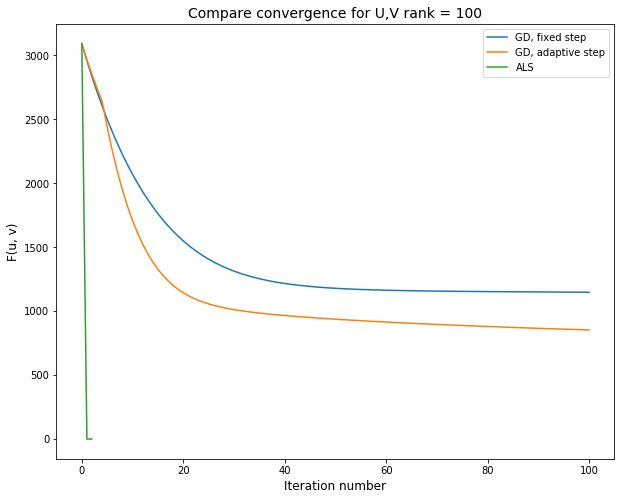

In [37]:
# Compare GD and ALS for sizes U, V equal to 100

step_u_fixed = 1e-6
step_v_fixed = 1e-6
step_u_vary = 1.0
step_v_vary = 1.0
step_divide_eps = 0.95
step_eps = 1e-6
iters = 100

r = int(rank)
u0 = np.random.rand(r, n)
v0 = np.random.rand(r, n)

u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
print("GD, fixed step. iters = ", niters, " F = ", F(u, v))

u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
print("GD, adaptive step. iters = ", niters, " F = ", F(u, v))

u, v, histALS, niters = ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, maxiter=iters)
print("ALS. iters = ", niters, " F = ", F(u, v))

plt.figure(figsize=(10, 8))
plt.plot(histGD, label="GD, fixed step")
plt.plot(histVaryGD, label="GD, adaptive step")
plt.plot(histALS, label="ALS")
plt.title("Compare convergence for U,V rank = " + str(r), fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("F(u, v)", fontsize=12)
plt.legend()


На графике показана сходимость методов для случая, когда размеры матриц $U$, $V$ совпадают с рангом матрицы $X$. Т.е. sizes = 100. Начальное приближение выбирается случайно.

Видно, что GD сходится очень медленно. Адаптивный шаг для GD улучшает сходимость, но не намного. В то время как метод ALS сходится всего за несколько итераций. Такое поведение связано с тем, что мы выбираем начальное приближение случайно и для GD оно оказывается неудачным.

GD, fixed step. iters =  100  F =  1002.08309207
GD, adaptive step. iters =  100  F =  825.93961864
ALS. iters =  77  F =  468.743463876


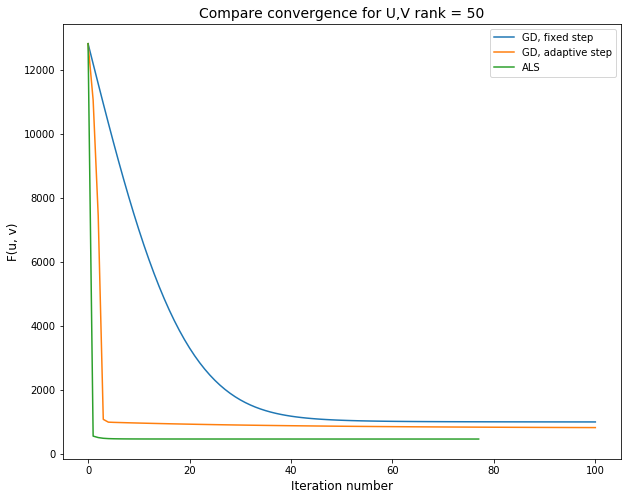

In [38]:
# Compare GD and ALS for sizes U, V less than 100

step_u_fixed = 1e-6
step_v_fixed = 1e-6
step_u_vary = 1.0
step_v_vary = 1.0
step_divide_eps = 0.95
step_eps = 1e-6
iters = 100

r = int(rank / 2)
u0 = np.random.rand(r, n)
v0 = np.random.rand(r, n)

u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
print("GD, fixed step. iters = ", niters, " F = ", F(u, v))

u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
print("GD, adaptive step. iters = ", niters, " F = ", F(u, v))

u, v, histALS, niters = ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, maxiter=iters)
print("ALS. iters = ", niters, " F = ", F(u, v))

plt.figure(figsize=(10, 8))
plt.plot(histGD, label="GD, fixed step")
plt.plot(histVaryGD, label="GD, adaptive step")
plt.plot(histALS, label="ALS")
plt.title("Compare convergence for U,V rank = " + str(r), fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("F(u, v)", fontsize=12)
plt.legend()


На графике показана сходимость методов для случая, когда размеры матриц $U$, $V$ меньше ранга матрицы $X$. Т.е. sizes = 50 < 100. Начальное приближение выбирается случайно.

Видно, что GD с адаптивным шагом всего за пару итераций попадает в окрестность минимума и дальше очень медленно сходится к точному значению минимума функционала. GD с фиксированным шагом за 40 итераций попадает в окрестность минимума и ведет себя аналогично. Такое поведение GD по прежнему обусловлено неудачным случайным начальным приближением. 

Заметим также, что количество итераций в методе ALS значительно увеличилось.


GD, fixed step. iters =  100  F =  1396.88377953
GD, adaptive step. iters =  100  F =  741.979954187
ALS. iters =  100  F =  25789780.3021


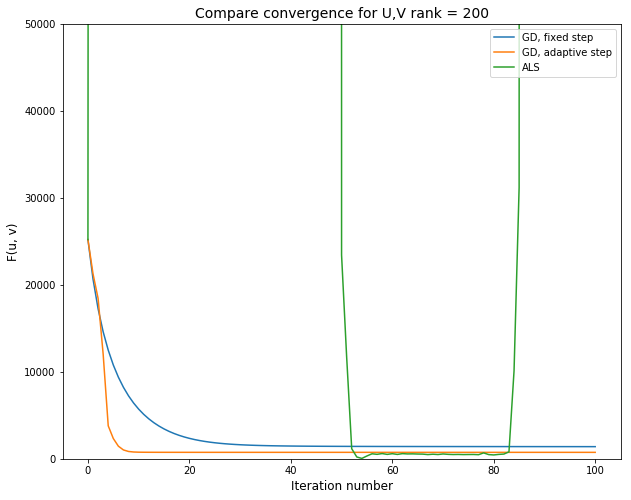

In [48]:
# Compare GD and ALS for size U, V greater than 100

step_u_fixed = 1e-6
step_v_fixed = 1e-6
step_u_vary = 1.0
step_v_vary = 1.0
step_divide_eps = 0.95
step_eps = 1e-6
iters = 100

r = int(2 * rank)
u0 = np.random.rand(r, n)
v0 = np.random.rand(r, n)

u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
print("GD, fixed step. iters = ", niters, " F = ", F(u, v))

u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
print("GD, adaptive step. iters = ", niters, " F = ", F(u, v))

u, v, histALS, niters = ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, maxiter=iters)
print("ALS. iters = ", niters, " F = ", F(u, v))

plt.figure(figsize=(10, 8))
plt.plot(histGD, label="GD, fixed step")
plt.plot(histVaryGD, label="GD, adaptive step")
plt.plot(histALS, label="ALS")
plt.title("Compare convergence for U,V rank = " + str(r), fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("F(u, v)", fontsize=12)
plt.ylim(0, 50000)
plt.legend()


На графике показана сходимость методов для случая, когда размеры матриц $U$, $V$ больше ранга матрицы $X$. Т.е. sizes = 200 > 100. Начальное приближение выбирается случайно.

Видно, что в этом случае ALS может и расходится.


### 4: Исследуйте зависимость от начального приближения и объясните её

||u0 - u|| and ||v0 - v||, where u, v - solutions:  9.99999999996e-06 1e-05
||u0 - u|| and ||v0 - v||, where u, v - solutions:  9.99999999996e-07 9.99999999998e-07
||u0 - u|| and ||v0 - v||, where u, v - solutions:  1.0000000001e-07 9.9999999973e-08
||u0 - u|| and ||v0 - v||, where u, v - solutions:  9.99999997873e-09 9.99999998033e-09
||u0 - u|| and ||v0 - v||, where u, v - solutions:  1.00000004033e-09 1.00000001238e-09


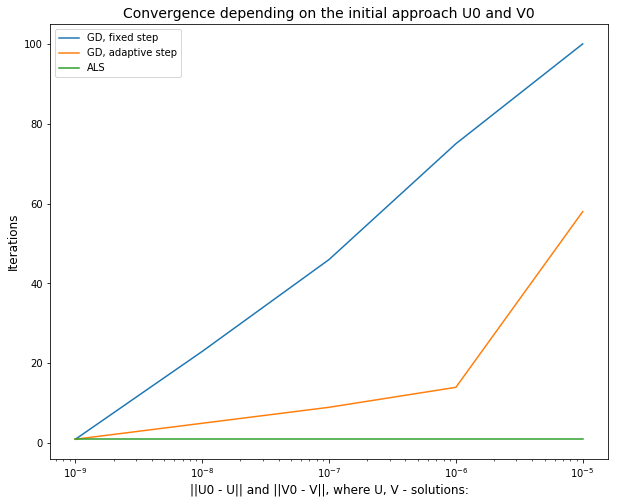

In [47]:
# How depends from initional values u0, v0?

step_u_fixed = 1e-6
step_v_fixed = 1e-6
step_u_vary = 1.0
step_v_vary = 1.0
step_divide_eps = 0.8
step_eps = 1e-6
iters = 100

r = int(rank)
err_UV = []
niters_GD = []
niters_VaryGD = []
niters_ALS = []
for i in range(5, 10):
    u0 = np.random.rand(r, n)
    v0 = np.random.rand(r, n)

    u0 = XU + u0 * (10.0**(-i) / norm(u0, 2))
    v0 = XV + v0 * (10.0**(-i) / norm(v0, 2))
    err_UV.append(10.0**(-i))
    print("||u0 - u|| and ||v0 - v||, where u, v - solutions: ", norm(u0 - XU, 2), norm(v0 - XV, 2))
    
    u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
    niters_GD.append(niters)
    
    u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
    niters_VaryGD.append(niters)
    
    u, v, histALS, niters = ALS(F, gradF_u, gradF_v, zeroGradF_u, zeroGradF_v, u0, v0, maxiter=iters)
    niters_ALS.append(niters)
  
plt.figure(figsize=(10, 8))
plt.plot(err_UV, niters_GD, label="GD, fixed step")
plt.plot(err_UV, niters_VaryGD, label="GD, adaptive step")
plt.plot(err_UV, niters_ALS, label="ALS")
plt.title("Convergence depending on the initial approach U0 and V0", fontsize=14)
plt.xlabel("||U0 - U|| and ||V0 - V||, where U, V - solutions:", fontsize=12)
plt.xscale("log")
plt.ylabel("Iterations", fontsize=12)
plt.legend()

На графике показано зависимость количества итераций методов от "близости" (по норме) начального приближения к решению задачи.

Чем ближе начальное приближение к решению задачи - тем требуется меньше итераций для метода GD. Это видно из графика.
Для быстрой сходимости GD важно попасть приближением рядом с решением задачи. Иначе алгоритм может сходится гораздо дольше.

### 5: Рассмотрите различные способы выбора шага в градиентном спуске и сделайте вывод о применимости каждого из них

GD, fixed step. iters =  5  F =  inf
GD, adaptive step. iters =  10  F =  1115.75164996


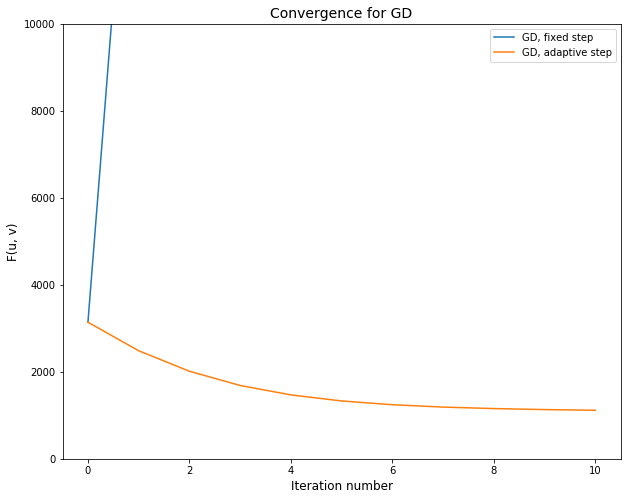

In [52]:
# GD: Fixed step vs Adaptive step

step_u_fixed = 1e-4
step_v_fixed = 1e-4
step_u_vary = 1.0
step_v_vary = 1.0
step_divide_eps = 0.8
step_eps = 1e-6
iters = 10

r = int(rank)
u0 = np.random.rand(r, n)
v0 = np.random.rand(r, n)

u, v, histGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_fixed, step_v_fixed, maxiter=iters)
print("GD, fixed step. iters = ", niters, " F = ", F(u, v))

u, v, histVaryGD, niters = GradientDescent(F, gradF_u, gradF_v, u0, v0, step_u_vary, step_v_vary, varyStep=True, stepDivideEps=step_divide_eps, stepEps=step_eps, maxiter=iters)
print("GD, adaptive step. iters = ", niters, " F = ", F(u, v))

plt.figure(figsize=(10, 8))
plt.plot(histGD, label="GD, fixed step")
plt.plot(histVaryGD, label="GD, adaptive step")
plt.title("Convergence for GD", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("F(u, v)", fontsize=12)
plt.ylim(0, 10000)
plt.legend()

Если выбирать достаточно большой шаг, то GD с фиксированныи шагом не будет сходится. В то время как GD с адаптивным шагом - сходится, это видно на графике. 

GD с адаптивным шагом лучше как раз потому что он не так чувствителен к набору параметров, в отличии от GD с фиксированным шагом, который очень чувствителен к шагу.

## Задача 2. PageRank

### 1: Опишите алгоритм PageRank (введите все необходимые обозначения)
### 2: Как связаны задачи нахождения PageRank'а и поиска максимального собственноо вектора и соответствующего ему собственного значения и почему?

#### PageRank
Consider graph $G = (V, E)$, where $V$ is set of nodes and $E$ is of edges. Assume $V = \{1, ..., n\}$ and write $i \rightarrow j$ to indicate that $(i, j) \in E$. The graph $G$ can be described by adjacency matrix $A \in R^{n \times n}$, such that $A_{ij} = 1$ if $j \rightarrow  i$ and $A_{ij} = 0$ otherwise.

The original formula by S. Brin and L. Page defines PageRank vector $\pi = (\pi_1, ..., \pi_n)^T$ of a graph $G$ as the solution of the following linear system:

$$ \pi_i = (1 - a) + a \sum_{j: j \rightarrow i} \frac{\pi_j}{d_j^{out}} $$

where $d_j^{out}$ is a number of outgoing edges from node $j$ of a graph $G$; $a \in (0, 1)$ is fixed constant called the damping factor, originally set to $a = 0.85$.

In Matrix form:

$$ (I - aM)\pi = (1 - a)e $$

where $M$ - matrix with non-negative elements (M is called link matrix) which is defined as:

\begin{equation}
  M_{ij} = \left\{
      \begin{array}{ccc}
          \displaystyle{\frac{A_{ij}}{d_j^{out}}  \text{ if }  d_j^{out} > 0 } \\
          \displaystyle{\frac{1}{n}  \text{ if }  d_j^{out} = 0 } \\
          \displaystyle{0  \text{ otherwise }}
      \end{array}
      \right.
\end{equation}

where $A$ - is a adjacency matrix of a graph $G$.

Note, that matrix $M$ is column stochastic matrix (sum of each column elements equal to 1). It is important!

#### Main Theorem

(as a consequence of the Perron–Frobenius theorem)

Let $\Gamma \in R^{n \times n}$ be the positive matrix, $0 < a < 1$:
$$ \Gamma = aM + \frac{1 - a}{n} e e^T $$


Then, $\rho(\Gamma) = 1$ and the vector $\pi$ is a Perron eigenvector.

$\Gamma$ is called Google Matrix

(Note: $\rho(\Gamma)$ the Perron eigenvalue of $\Gamma$ and any associated positive eigenvector is a Perron eigenvector)

Теорема выше и дает ответ на вопрос о том, как связана задача по нахождению собственного значения с PageRank. 
Из этой теоремы следует, что нам нужно найти максимальное собственное значение матрицы $\Gamma$, которое равно единице, 
собственный вектор для этого собств. значения и будет PageRank. 

Максимальное собственное значение можно искать степенным методом.

#### Dangling nodes problem

В общем случае матрица $A$ имеет нулевые столбцы, так называемые dangling nodes (случай когда $d_j^{out}=0$). Чтобы сделать матрицу $M$ стохастической и избежать этой проблемы, достаточно заменить все нулевые столбцы на столбцы состоящие из $\frac{1}{n}$.

### 3: Реализуйте степенной метод нахождения максимального собственного вектора

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

import scipy.sparse as spsp
import scipy.sparse.linalg as splinalg

from scipy import linalg
from scipy.linalg import norm

def rand_matrix(n, rank):
    mat = 0.0 * np.eye(n)
    for i in range(rank):
        a = np.random.randn(n).reshape(1, n)
        b = np.random.randn(n).reshape(n, 1)
        mat = mat + b.dot(a)
        
    return mat


def PowerMethod(A, y0, eps=1e-5, maxiter=100):
    x = y0 / norm(y0, 2)
    l = 0.0
    
    err = 1.0
    hist = [l]
    
    n_iter = 0
    while err > eps and n_iter < maxiter:
        lold = l
        
        y = A.dot(x)
        x = y / norm(y, 2)
        
        l = x.T.dot(A.dot(x))
        
        err = abs(l - lold)
        hist.append(l)
        
        n_iter = n_iter + 1
        
    return x, l, n_iter, hist

# Power Method for Google matrix
def PM_GoogleMatrix(GM, a, n, y0, eps=1e-5, maxiter=100):
    x = y0 / norm(y0, 2)
    l = 0.0
    
    err = 1.0
    hist = [l]

    n_iter = 0
    while err > eps and n_iter < maxiter:
        lold = l
        
        y = GM.matvec(x)
        x = y / norm(y, 2)
        l = x.T.dot(GM.matvec(x))
        
        err = abs(l - lold)
        hist.append(l)
        
        n_iter = n_iter + 1
       
    return x, l, n_iter, hist

Iters:  71  $lambda:  3.18394195144
Lymbdas from np.linalg.eig: 
 [-2.97265019  3.18400397  2.62481172 -2.10562856  1.81633861  1.27487012
  0.98751309 -1.27151845 -0.75979805  0.00942781]


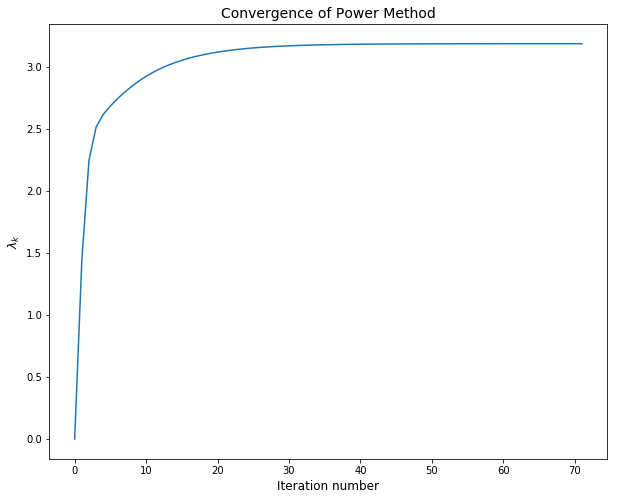

In [2]:
# Test for Power Method, compare with linalg.eig

n = 10
A = np.random.randn(n, n)
# do symmetric
A = (A + A.T) / 2.0 

v0 = np.random.randn(n).reshape(n, 1)

v, l, niters, hist = PowerMethod(A, v0, maxiter=1000)
print("Iters: ", niters, " $lambda: ", l[0, 0])

L, V = np.linalg.eig(A)
print("Lymbdas from np.linalg.eig: \n", L)

plt.figure(figsize=(10, 8))
plt.plot(hist)
plt.title("Convergence of Power Method", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("$\lambda_k$", fontsize=12)


На графике показана сходимость степенного метода для случайной симметричной матрицы 10 на 10.

### 4: Найдите с помощью степенного метода TOP-10 статей по величине PageRank'a по физике высоких энергий в соответствии с [графом](https://snap.stanford.edu/data/cit-HepTh.html). Результат должен быть воспроизводим, используйте разреженные матрицы для работы с матрицей смежности графа

In [27]:
# Read graph and build matrix

Graph = {}
NodeMap = {}

k = 0

with open('Cit-HepTh.txt') as f:
    for line in f:
        NodeFrom, NodeTo = line.split()
        NodeFrom, NodeTo = int(NodeFrom), int(NodeTo)
        
        if NodeMap.get(NodeFrom) == None:
            NodeMap[NodeFrom] = k
            k = k + 1
        
        if NodeMap.get(NodeTo) == None:
            NodeMap[NodeTo] = k
            k = k + 1
        
        if Graph.get(NodeFrom) == None:
            Graph[NodeFrom] = [NodeTo]
        else:
            Graph[NodeFrom].append(NodeTo)

n = len(NodeMap.values())
print("Nodes: ", n, k)

# link matrix
M = spsp.lil_matrix((n, n))

#for nodeFrom in Graph.keys():
#    NodesTo = Graph[nodeFrom]
#    d_out = len(NodesTo)
#    
#    for nodeTo in NodesTo:
#        # if j->i then Aij = 1
#        M[NodeMap[nodeTo], NodeMap[nodeFrom]] = (1.0 / d_out)

dang_nodes = []
for j in range(0, n):
    nodeFrom = list(NodeMap.keys())[j]
    
    if Graph.get(nodeFrom) == None:
        # dangling nodes
        dang_nodes.append(j)
        
    else:
        NodesTo = Graph[nodeFrom]
        d_out = len(NodesTo)
    
        for nodeTo in NodesTo:
            # if j->i then Aij = 1
            M[NodeMap[nodeTo], NodeMap[nodeFrom]] = (1.0 / d_out)
        
print("Dangling nodes: ", len(dang_nodes))

print("Nonzero: ", M.nnz)
M.tocsr()

print("Building Link Matrix M is successed!")


Nodes:  27770 27770
Dangling node:  2711
Nonzero:  352807
Building Link Matrix M is successed!


In [39]:
# Generate Linear Operator for Google Matrix

a = 0.85 # damping factor
e = np.ones((n, 1))

def GoogleMatrixMV(x):
    return ((1.0 - a) / n) * e.dot(e.T.dot(x)) + a * M.dot(x) + a * (1.0 / n) * sum(x[dang_nodes])
    
GM = splinalg.LinearOperator((n, n), matvec=GoogleMatrixMV)



In [40]:
# Find Perron eigenvalue and Perron eigenvector 

print("n and a: ", n, a)
print("--------------------------------------------------")

L, V = splinalg.eigs(GM, k=2, maxiter=1000)
print("scipy sparse eigs func: ", L)

v0 = np.abs(np.random.rand(n, 1))
v1, l1, niters1, hist1 = PM_GoogleMatrix(GM, a, n, v0, eps=1e-5, maxiter=100)
print("... Iters: ", niters1, " Lymbda: ", l1[0, 0])


n and a:  27770 0.85
--------------------------------------------------
scipy sparse eigs func:  [-0.85+0.j  1.00+0.j]
... Iters:  38  Lymbda:  1.00005353909


Sum of all PageRanks:  [ 27769.99999999]
--------------------------------------------------------
Top 10
1 PageRank:  172.556372697  ID Node:  9207016
2 PageRank:  168.969875625  ID Node:  9407087
3 PageRank:  156.154402075  ID Node:  9201015
4 PageRank:  124.12269012  ID Node:  9503124
5 PageRank:  116.910773232  ID Node:  9510017
6 PageRank:  106.106723263  ID Node:  9402044
7 PageRank:  93.5220501785  ID Node:  9711200
8 PageRank:  91.373585752  ID Node:  9410167
9 PageRank:  86.770823566  ID Node:  9408099
10 PageRank:  80.4118500515  ID Node:  9402002


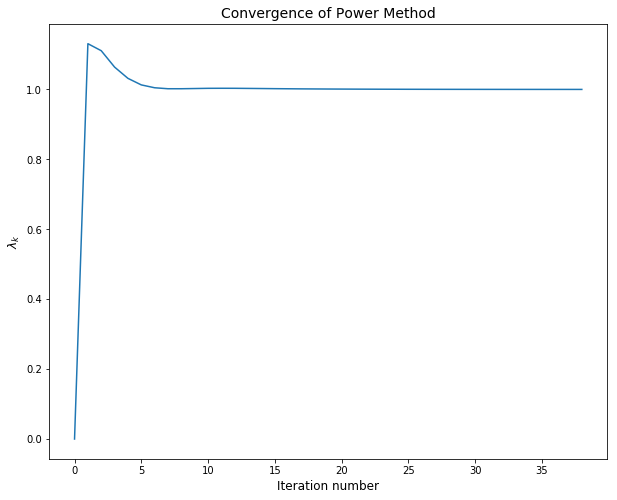

In [44]:
# Show Top 10 and show convergence

#normalize v: eT * v = n
v1 = (v1 / norm(v1, 1)) * n
print("Sum of all PageRanks: ", sum(v1))

#idmax = np.argmax(v1)
#prmax = v1[idmax, 0]
#print("id max and pageRank max: ", idmax, prmax)
#print("ID node: ", list(NodeMap.keys())[list(NodeMap.values()).index(idmax)])

print("--------------------------------------------------------")
vsort = np.argsort(v1[:,0])
topv = vsort[-10:][::-1]
print("Top 10")
num = 1
for i in topv:
    print(num, "PageRank: ", v1[i, 0], " ID Node: ", list(NodeMap.keys())[list(NodeMap.values()).index(i)])
    num = num + 1
    
plt.figure(figsize=(10, 8))
plt.plot(hist1)
plt.title("Convergence of Power Method", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("$\lambda_k$", fontsize=12)


### 5: Сравните теоретическую и экспериментальную сходимость степенного метода для этого графа. Нарисуйте график и объясните, почему он выглядит именно так?

lambda_1:  1.0  and lambda_2:  0.85


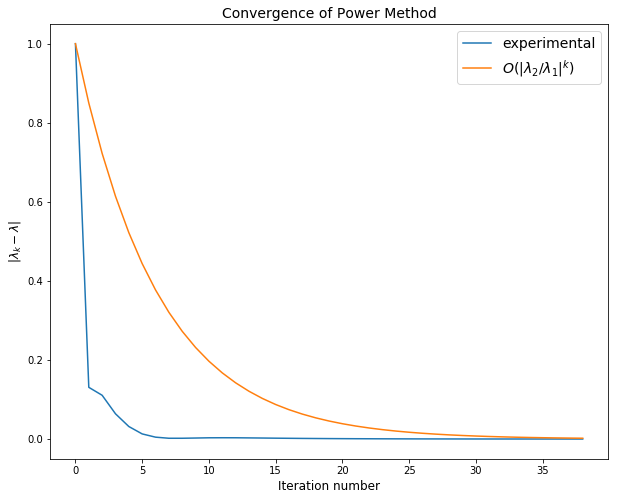

In [57]:
l1 = max(abs(L))
l2 = min(abs(L))
print("lambda_1: ", l1, " and lambda_2: ", l2)

plt.figure(figsize=(10, 8))
plt.plot([abs(l1 - l) for l in hist1], label="experimental")
plt.plot([(l2/l1)**k for k in range(len(hist1))], label="$O(|\lambda_2 / \lambda_1|^k)$")
plt.title("Convergence of Power Method", fontsize=14)
plt.xlabel("Iteration number", fontsize=12)
plt.ylabel("$|\lambda_k - \lambda|$", fontsize=12)
plt.legend(fontsize=14)

Теоретическая сходимость степенного метода определяется как:

$$ |\lambda_1 - \lambda_{(k)}| = O(\frac{|\lambda_2|}{|\lambda_1|}^k)$$

Выпишем еще раз нашу матрицу:
$$ \Gamma = aM + \frac{1 - a}{n} e e^T $$
Мы знаем $|\lambda_1| = 1$ (Perron eigenvalue). Также есть теорема, доказывающая, что
$|\lambda_2| \le a$ для этой матрицы. Поэтому параметр $a$ создает "зазор" между собственными значениями этой матрицы и улучшает сходимость степенного метода для этой матрицы. Если выбирать большой $a$, то "зазор" будет уменьшаться и сходимость существенно ухудшаться.

Все теоретические выкладки только подтверждаются вычислениями и графиками выше.

## Задача 3. Регуляризация

### 1: Сгенерируйте случайную малоранговую матрицу $X$ $500 \times 100$ ранга $10$

### 2: Сгенерируйте случайный вектор $w$ размера $100$ и целевой вектор 
### $$ y = Xw + \varepsilon, $$
### где $\varepsilon$ - вектор с элементами из нормального распределения с нулевым средним и дисперсией $0.01$. 

In [46]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from numpy.linalg import norm
from sklearn import linear_model

n_samples, n_features = 500, 100
rank = 10

XU = np.random.rand(rank, n_samples)
XV = np.random.rand(rank, n_features)
X = XU.T.dot(XV)

w = np.random.rand(n_features, 1)

Xw = X.dot(w)
Xw1d = X.dot(w).ravel()

# N(0, 0.01):
eps = 0.1 * np.random.randn(n_samples, 1) + 0

y = X.dot(w) + eps
y1d = y.ravel()

### 3: Сравните разреженность и точность решения, которое дают методы регуляризации рассмотренные на лекции. Сделайте вывод об их эффективности. Рассмотрите, как автоматический подбор параметра регуляризации, так и эвристический подбор. Сравните эффективность методов. 


In [47]:
# Compare different linear models

clfLasso = linear_model.Lasso(alpha=1.0) # fit_intercept=False
outLasso = clfLasso.fit(X, y1d) 
print("Lasso score(X, Xw): ", outLasso.score(X, Xw1d), " | Lasso score(X, Xw + eps): ", outLasso.score(X, y1d)) 
print("|y - y_predict|: ", norm(outLasso.predict(X) - Xw1d, 2))
print("Nonzero in w: ", np.count_nonzero(outLasso.coef_))
print("--------------------------------------------------------------------------------------")

clfCVLasso = linear_model.LassoCV() 
outCVLasso = clfCVLasso.fit(X, y1d) 
print("CV Lasso score(X, Xw): ", outCVLasso.score(X, Xw1d), " | CV Lasso score(X, Xw + eps): ", outCVLasso.score(X, y1d)) 
print("|y - y_predict|: ", norm(outCVLasso.predict(X) - Xw1d, 2))
print("Nonzero in w: ", np.count_nonzero(outCVLasso.coef_))
print("--------------------------------------------------------------------------------------")

clfRidge = linear_model.Ridge(alpha=1.0) 
outRidge = clfRidge.fit(X, y1d) 
print("Ridge score(X, Xw): ", outRidge.score(X, Xw1d), " | Ridge score(X, Xw + eps): ", outRidge.score(X, y1d)) 
print("|y - y_predict|: ", norm(outRidge.predict(X) - Xw1d, 2))
print("Nonzero in w: ", np.count_nonzero(outRidge.coef_))
print("--------------------------------------------------------------------------------------")

clfCVRidge = linear_model.RidgeCV() 
outCVRidge = clfCVRidge.fit(X, y1d) 
print("CV Ridge score(X, Xw): ", outCVRidge.score(X, Xw1d), " | CV Ridge score(X, Xw + eps): ", outCVRidge.score(X, y1d)) 
print("|y - y_predict|: ", norm(outCVRidge.predict(X) - Xw1d, 2))
print("Nonzero in w: ", np.count_nonzero(outCVRidge.coef_))
print("--------------------------------------------------------------------------------------")

clfEN = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.1)
outEN = clfEN.fit(X, y1d)
print("ElasticNet score(X, Xw): ", outEN.score(X, Xw1d), " | ElasticNet score(X, Xw + eps): ", outEN.score(X, y1d)) 
print("|y - y_predict|: ", norm(outEN.predict(X) - Xw1d, 2))
print("Nonzero in w: ", np.count_nonzero(outEN.coef_))
print("--------------------------------------------------------------------------------------")

clfCVEN = linear_model.ElasticNetCV()
outCVEN = clfCVEN.fit(X, y1d)
print("CV ElasticNet score(X, Xw): ", outCVEN.score(X, Xw1d), " | CV ElasticNet score(X, Xw + eps): ", outCVEN.score(X, y1d)) 
print("|y - y_predict|: ", norm(outCVEN.predict(X) - Xw1d, 2))
print("Nonzero in w: ", np.count_nonzero(outCVEN.coef_))
print("--------------------------------------------------------------------------------------")

#clfHubber = linear_model.HuberRegressor()
#outHubber = clfHubber.fit(X, y1d)


Lasso score(X, Xw):  0.991901517048  | Lasso score(X, Xw + eps):  0.991911519034
|y - y_predict|:  46.251445379
Nonzero in w:  10
--------------------------------------------------------------------------------------
CV Lasso score(X, Xw):  0.999996398099  | CV Lasso score(X, Xw + eps):  0.99997897401
|y - y_predict|:  0.975414843122
Nonzero in w:  20
--------------------------------------------------------------------------------------
Ridge score(X, Xw):  0.999999205715  | Ridge score(X, Xw + eps):  0.999981807897
|y - y_predict|:  0.458048743699
Nonzero in w:  100
--------------------------------------------------------------------------------------
CV Ridge score(X, Xw):  0.999999310792  | CV Ridge score(X, Xw + eps):  0.999981833066
|y - y_predict|:  0.426676507125
Nonzero in w:  100
--------------------------------------------------------------------------------------
ElasticNet score(X, Xw):  0.996839598199  | ElasticNet score(X, Xw + eps):  0.996846277423
|y - y_predict|:  28.8

/home/andr/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


CV ElasticNet score(X, Xw):  0.999983891698  | CV ElasticNet score(X, Xw + eps):  0.999968198156
|y - y_predict|:  2.06275833764
Nonzero in w:  84
--------------------------------------------------------------------------------------


/home/andr/anaconda3/lib/python3.6/site-packages/sklearn/linear_model/coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


Видно, что метод Ridge дает наибольшую точность и наибольшее количество ненулевых признаков. Это не очень хорошо, потому 
что метод сильно переобучивается.

Метод Lasso наоборот, наихудшую точность среди всех и наименьшее количество ненулевых признаков. И ElasticNet среднее между Ridge и Lasso. 

Также из результатов видно, что автоматический подбор регуляризации (CV) ведет себя лучше, чем ручной.

### 4: Проведите аналогичный эксперимент, но на данных, в которых целевой вектор сгенерирован так, что он хорошо аппроксимируется как одним признаком, так и линейной комбинацией двух или трёх других признаков. Выделяют ли методы регуляризации подобные зависимости в данных? Почему?

In [48]:
# Generate

AU = np.random.rand(rank, n_samples)
AV = np.random.rand(rank, n_features)
A = AU.T.dot(AV)

wA = 0.0 * np.random.randn(n_features) 
for i in range(1):
    wi = np.random.randint(n_features)
    r = np.random.rand(1)[0]
    wA[wi] = r

print("nnz w: ", np.count_nonzero(wA))

yA = A.dot(wA.reshape(n_features, 1))
yA = yA.ravel()

# N(0, 0.01):
epsA = 0.1 * np.random.randn(n_samples) + 0
yA_eps = yA + epsA


nnz w:  1


In [49]:
clfCVLasso = linear_model.LassoCV() 
outCVLasso = clfCVLasso.fit(A, yA_eps) 
print("CV Lasso score(X, Xw): ", outCVLasso.score(A, yA), " | CV Lasso score(X, Xw + eps): ", outCVLasso.score(A, yA_eps)) 
print("Nonzero in w: ", np.count_nonzero(outCVLasso.coef_))
print("--------------------------------------------------------------------------------------")

clfCVRidge = linear_model.RidgeCV() 
outCVRidge = clfCVRidge.fit(A, yA_eps) 
print("CV Ridge score(X, Xw): ", outCVRidge.score(A, yA), " | CV Ridge score(X, Xw + eps): ", outCVRidge.score(A, yA_eps)) 
print("Nonzero in w: ", np.count_nonzero(outCVRidge.coef_))
print("--------------------------------------------------------------------------------------")

clfCVEN = linear_model.ElasticNetCV()
outCVEN = clfCVEN.fit(A, yA_eps)
print("CV ElasticNet score(X, Xw): ", outCVEN.score(A, yA), " | CV ElasticNet score(X, Xw + eps): ", outCVEN.score(A, yA_eps)) 
print("Nonzero in w: ", np.count_nonzero(outCVEN.coef_))
print("--------------------------------------------------------------------------------------")

CV Lasso score(X, Xw):  0.999460792976  | CV Lasso score(X, Xw + eps):  0.961845392316
Nonzero in w:  2
--------------------------------------------------------------------------------------
CV Ridge score(X, Xw):  0.999502588457  | CV Ridge score(X, Xw + eps):  0.962083713196
Nonzero in w:  100
--------------------------------------------------------------------------------------
CV ElasticNet score(X, Xw):  0.999257922254  | CV ElasticNet score(X, Xw + eps):  0.961883936962
Nonzero in w:  7
--------------------------------------------------------------------------------------


Как видно из результатов, подобные зависимости хуже всего различает метод регуляризации Ridge. Методы Lasso и ElasticNet хорошо справляются с этой задачей.

### 5: Добавьте в сгенерированную выборку несколько (5-10) выбросов, то есть таких строк и соответствующих им значений в $y$, что они не подчиняются ранее заданному закону.

In [50]:
# Create trash in y

epsT = eps.copy()
for i in range(10):
    yi = np.random.randint(n_samples)
    r = np.random.rand(1)[0]
    epsT[yi] = 1000.0*r
    #print('eps[{0}] = {1} turn to epsT[{0}] = {2}'.format(yi, eps[yi], epsT[yi]))
    
yT = X.dot(w) + epsT
yT1d = yT.ravel()

### 6: Проверьте как изменится точность решения задачи для ранее рассмотренных методов
### 7: Сравните предыдущие методы регуляризации с [регуляризацией Huber'a](https://en.wikipedia.org/wiki/Huber_loss). Какой способ устойчивее к выбросам и почему?

In [51]:
# What is better?

clfLasso = linear_model.Lasso(alpha=1.0) 
outLasso = clfLasso.fit(X, yT1d) 
print("Lasso score(X, Xw): ", outLasso.score(X, Xw1d), " | Lasso score(X, Xw + eps): ", outLasso.score(X, yT1d)) 
print("|y - y_predict|: ", norm(outLasso.predict(X) - Xw1d, 2))
print("-------------------------------------------")

clfCVLasso = linear_model.LassoCV() 
outCVLasso = clfCVLasso.fit(X, yT1d) 
print("CV Lasso score(X, Xw): ", outCVLasso.score(X, Xw1d), " | CV Lasso score(X, Xw + eps): ", outCVLasso.score(X, yT1d)) 
print("|y - y_predict|: ", norm(outCVLasso.predict(X) - Xw1d, 2))
print("-------------------------------------------")

clfRidge = linear_model.Ridge(alpha=1.0) 
outRidge = clfRidge.fit(X, yT1d) 
print("Ridge score(X, Xw): ", outRidge.score(X, Xw1d), " | Ridge score(X, Xw + eps): ", outRidge.score(X, yT1d)) 
print("|y - y_predict|: ", norm(outRidge.predict(X) - Xw1d, 2))
print("-------------------------------------------")

clfCVRidge = linear_model.RidgeCV() 
outCVRidge = clfCVRidge.fit(X, yT1d) 
print("CV Ridge score(X, Xw): ", outCVRidge.score(X, Xw1d), " | CV Ridge score(X, Xw + eps): ", outCVRidge.score(X, yT1d)) 
print("|y - y_predict|: ", norm(outCVRidge.predict(X) - Xw1d, 2))
print("-------------------------------------------")

clfEN = linear_model.ElasticNet(alpha=1.0, l1_ratio=0.1)
outEN = clfEN.fit(X, yT1d)
print("ElasticNet score(X, Xw): ", outEN.score(X, Xw1d), " | ElasticNet score(X, Xw + eps): ", outEN.score(X, yT1d)) 
print("|y - y_predict|: ", norm(outEN.predict(X) - Xw1d, 2))
print("-------------------------------------------")

clfCVEN = linear_model.ElasticNetCV()
outCVEN = clfCVEN.fit(X, yT1d)
print("CV ElasticNet score(X, Xw): ", outCVEN.score(X, Xw1d), " | CV ElasticNet score(X, Xw + eps): ", outCVEN.score(X, yT1d)) 
print("|y - y_predict|: ", norm(outCVEN.predict(X) - Xw1d, 2))
print("-------------------------------------------")

clfHubber = linear_model.HuberRegressor()
outHubber = clfHubber.fit(X, yT1d)
print("Hubber score(X, Xw): ", outHubber.score(X, Xw1d), " | Hubber score(X, Xw + eps): ", outHubber.score(X, yT1d)) 
print("|y - y_predict|: ", norm(outHubber.predict(X) - Xw1d, 2))
print("-------------------------------------------")

Lasso score(X, Xw):  0.606224270412  | Lasso score(X, Xw + eps):  0.0723442937387
|y - y_predict|:  322.513534981
-------------------------------------------
CV Lasso score(X, Xw):  0.637030817407  | CV Lasso score(X, Xw + eps):  0.0603636495803
|y - y_predict|:  309.640920427
-------------------------------------------
Ridge score(X, Xw):  0.49772336892  | Ridge score(X, Xw + eps):  0.0736818823726
|y - y_predict|:  364.246141025
-------------------------------------------
CV Ridge score(X, Xw):  0.512580528602  | CV Ridge score(X, Xw + eps):  0.0736615504109
|y - y_predict|:  358.818569302
-------------------------------------------
ElasticNet score(X, Xw):  0.700826990613  | ElasticNet score(X, Xw + eps):  0.0680162080688
|y - y_predict|:  281.11542614
-------------------------------------------
CV ElasticNet score(X, Xw):  0.675766740805  | CV ElasticNet score(X, Xw + eps):  0.0609657226362
|y - y_predict|:  292.652510459
-------------------------------------------
Hubber score(X, 

Из результатов видно, что метод Hubber ведет себя устойчивее всех к выбросам.

### 8: Получите аналитическое решение задачи
### $$ \min_w \|Xw - y\|^2_2 + \| \lambda \odot w \|^2_2, $$
### где $\lambda$ - вектор такой же размерности, что и $w$, $\odot$ означает поэлементное умножение двух векторов

Решение:

$$ \mathcal{L} = ||{Xw-y}^2|| + ||{\lambda \odot w}^2|| $$

$$ \nabla\mathcal{L} = 2X^T(Xw-y) + 2\lambda^2 \odot w $$

где $\lambda^2 = \lambda \odot \lambda$
    
$$\nabla\mathcal{L} = 0 \Rightarrow$$

$$ 2X^T(Xw-y) + 2\lambda^2 \odot w = 0 \Rightarrow$$

$$ (\lambda^{-2} \odot X^TX + I_n)w = \lambda^{-2} \odot X^Ty $$

$$ w = (\lambda^{-2} \odot X^TX + I_n)^{-1}\lambda^{-2} \odot X^Ty $$


